<a href="https://colab.research.google.com/github/yang2k1/Project_ML_2024_19130062/blob/main/Project_ML_2024_19130062.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/DataSet'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/DataSet


# Khai báo thư viện

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Đọc dữ liệu

In [ ]:
dataset = pd.read_csv('Boats.csv')
dataset.head()

,Unnamed: 0,id,type,boatClass,make,model,year,condition,length_ft,beam_ft,...,minEngineYear,engineCategory,price,sellerId,city,state,zip,created_date,created_month,created_year
0,1,7252689,power,power-center,Aquasport,210 CC,1992,used,21.0,8.50,...,NaN,outboard-4s,16500.0,217053,Englewood,FL,34224,2019-10-16,10,2019
1,3,7228300,power,power-sportcruiser,Formula,400 Super Sport,2018,used,40.0,11.00,...,2018.0,inboard-outboard,539000.0,44260,Harsens Island,MI,48028,2019-09-24,9,2019
2,5,7271336,power,power-deck,Bayliner,Element 180,2020,new,18.0,7.42,...,2019.0,outboard-4s,26995.0,220570,Marietta,OH,45750,2019-11-02,11,2019
3,6,7222952,power,power-expresscruiser,Regal,32 Express,2015,used,32.0,10.33,...,NaN,multiple,169995.0,34834,North Charleston,SC,29405,2019-09-19,9,2019
4,8,6824832,power,power-aft,Carver,440 Aft Cabin Motor Yacht,1994,used,44.0,15.00,...,1994.0,inboard,109900.0,17942,Middle River,MD,21220,2018-08-29,8,2018


# Thông tin dataset

In [ ]:
# Xóa cột id
dataset = dataset.drop(columns=['Unnamed: 0','id'])

dataset.info()

# Đếm số phần tử riêng biệt
print('\n')
dataset.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18903 entries, 0 to 18902
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            18903 non-null  object 
 1   boatClass       18903 non-null  object 
 2   make            18903 non-null  object 
 3   model           18868 non-null  object 
 4   year            18903 non-null  int64  
 5   condition       18903 non-null  object 
 6   length_ft       18903 non-null  float64
 7   beam_ft         12399 non-null  float64
 8   dryWeight_lb    7094 non-null   float64
 9   hullMaterial    18903 non-null  object 
 10  fuelType        15951 non-null  object 
 11  numEngines      18903 non-null  int64  
 12  totalHP         18055 non-null  float64
 13  maxEngineYear   2205 non-null   float64
 14  minEngineYear   2174 non-null   float64
 15  engineCategory  8410 non-null   object 
 16  price           18903 non-null  float64
 17  sellerId        18903 non-null 

type                 3
boatClass           72
make               960
model             7899
year                80
condition            2
length_ft          599
beam_ft            350
dryWeight_lb      1160
hullMaterial         9
fuelType             4
numEngines           5
totalHP            286
maxEngineYear       67
minEngineYear       66
engineCategory       9
price             6074
sellerId          1375
city              1149
state               49
zip               1046
created_date      1424
created_month       12
created_year        16
dtype: int64

# Số lượng phân bố của từng cột

In [ ]:
numerical_featues=(dataset.select_dtypes([int,float]).columns).tolist()
numerical_featues

['year',
 'length_ft',
 'beam_ft',
 'dryWeight_lb',
 'numEngines',
 'totalHP',
 'maxEngineYear',
 'minEngineYear',
 'price',
 'sellerId',
 'created_month',
 'created_year']

In [ ]:
dataset.select_dtypes([object]).nunique()

type                 3
boatClass           72
make               960
model             7899
condition            2
hullMaterial         9
fuelType             4
engineCategory       9
city              1149
state               49
zip               1046
created_date      1424
dtype: int64

In [ ]:
non_numerical_featues=[
 'type',
 'boatClass',
 'make',
 'model',
 'condition',
 'hullMaterial',
 'fuelType',
 'engineCategory',
 'state',
]

In [ ]:
dataset=dataset[numerical_featues+non_numerical_featues]

In [ ]:
print({'mean':dataset['price'].mean(),
       'median':dataset['price'].median(),
       'std':dataset['price'].std(),
       'min':dataset['price'].min(),
       'max':dataset['price'].max()
       })

{'mean': 647146.880930011, 'median': 34195.0, 'std': 73095667.96677485, 'min': 500.0, 'max': 9999999999.0}


In [ ]:
dataset=dataset[dataset['price']!=9999999999]
dataset=dataset[dataset['price']!=999999999]

#  Biểu đồ histogram của price

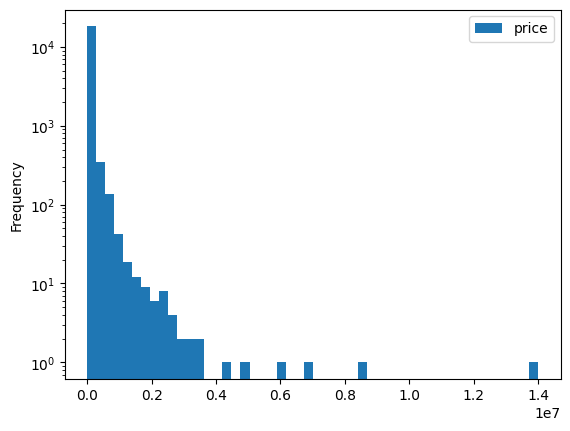

In [ ]:
dataset.plot.hist(y='price',bins=50)
plt.yscale('log')

# Handling Missing Values

In [ ]:
print(dataset.isnull().sum())

# Fill missing values for numerical features with the median
for feature in numerical_featues:
    dataset[feature].fillna(dataset[feature].median(), inplace=True)

# Fill missing values for categorical features with the most frequent value
for feature in non_numerical_featues:
    dataset[feature].fillna(dataset[feature].mode()[0], inplace=True)

year                  0
length_ft             0
beam_ft            6504
dryWeight_lb      11807
numEngines            0
totalHP             846
maxEngineYear     16696
minEngineYear     16727
price                 0
sellerId              0
created_month         0
created_year          0
type                  0
boatClass             0
make                  0
model                35
condition             0
hullMaterial          0
fuelType           2952
engineCategory    10491
state                 0
dtype: int64


# Encoding Categorical Variables

In [ ]:
from sklearn import preprocessing

print(dataset.columns)

# Ensure correct column names
non_numerical_features = [
    'type', 'boatClass', 'make', 'model', 'condition',
    'hullMaterial', 'fuelType', 'engineCategory', 'state'
]

# Encode labels in non-numerical features
label_encoder = preprocessing.LabelEncoder()
for column in non_numerical_features:
    if column in dataset.columns:
        dataset[column] = label_encoder.fit_transform(dataset[column])

Index(['year', 'length_ft', 'beam_ft', 'dryWeight_lb', 'numEngines', 'totalHP',
       'maxEngineYear', 'minEngineYear', 'price', 'sellerId', 'created_month',
       'created_year', 'type', 'boatClass', 'make', 'model', 'condition',
       'hullMaterial', 'fuelType', 'engineCategory', 'state'],
      dtype='object')


# Standardize Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset[numerical_featues] = scaler.fit_transform(dataset[numerical_featues])


# Splitting the Data

In [ ]:
data_2_train = dataset.copy()

y = data_2_train['price']
data_2_train.drop(["price"], axis=1, inplace=True)
X = data_2_train

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, random_state = 0)
# chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

# Training

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)



In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


In [ ]:
# !pip install scikeras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the Neural Network model
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer for regression task
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Prepare data for neural network
X_train_nn = X_train
X_test_nn = X_test

# Build and train the model
nn_model = build_nn_model(X_train_nn.shape[1])
nn_model.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict and evaluate the model
y_pred_nn = nn_model.predict(X_test_nn).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)



Epoch 1/50
355/355 [==============================] - 2s 2ms/step - loss: 0.4337 - mean_absolute_error: 0.1918 - val_loss: 1.5525 - val_mean_absolute_error: 0.1776
Epoch 2/50
355/355 [==============================] - 1s 2ms/step - loss: 0.3093 - mean_absolute_error: 0.1559 - val_loss: 1.3592 - val_mean_absolute_error: 0.1691
Epoch 3/50
355/355 [==============================] - 1s 2ms/step - loss: 0.2505 - mean_absolute_error: 0.1432 - val_loss: 1.2164 - val_mean_absolute_error: 0.1546
Epoch 4/50
355/355 [==============================] - 1s 2ms/step - loss: 0.2199 - mean_absolute_error: 0.1355 - val_loss: 1.0322 - val_mean_absolute_error: 0.1542
Epoch 5/50
355/355 [==============================] - 1s 3ms/step - loss: 0.1710 - mean_absolute_error: 0.1305 - val_loss: 1.0378 - val_mean_absolute_error: 0.1571
Epoch 6/50
355/355 [==============================] - 1s 3ms/step - loss: 0.1444 - mean_absolute_error: 0.1295 - val_loss: 1.1135 - val_mean_absolute_error: 0.1464
Epoch 7/50
355/3

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "MAE", "MSE", "R²"]

# Add rows for selected features
table.add_row(["Decision Tree", mae_dt, mse_dt, r2_dt])
table.add_row(["Random Forest", mae_rf, mse_rf, r2_rf])
table.add_row(["Neural Network", mae_nn, mse_nn, r2_nn])

print(table)


+----------------+---------------------+---------------------+--------------------+
|     Model      |         MAE         |         MSE         |         R²         |
+----------------+---------------------+---------------------+--------------------+
| Decision Tree  | 0.09960342549543073 |  0.3534449634133214 | 0.5004537300014172 |
| Random Forest  | 0.06819699357985562 | 0.10045028141839621 | 0.8580272217822287 |
| Neural Network | 0.10433448342020525 | 0.16881479835475727 | 0.7614032973499618 |
+----------------+---------------------+---------------------+--------------------+


# Feature Selection

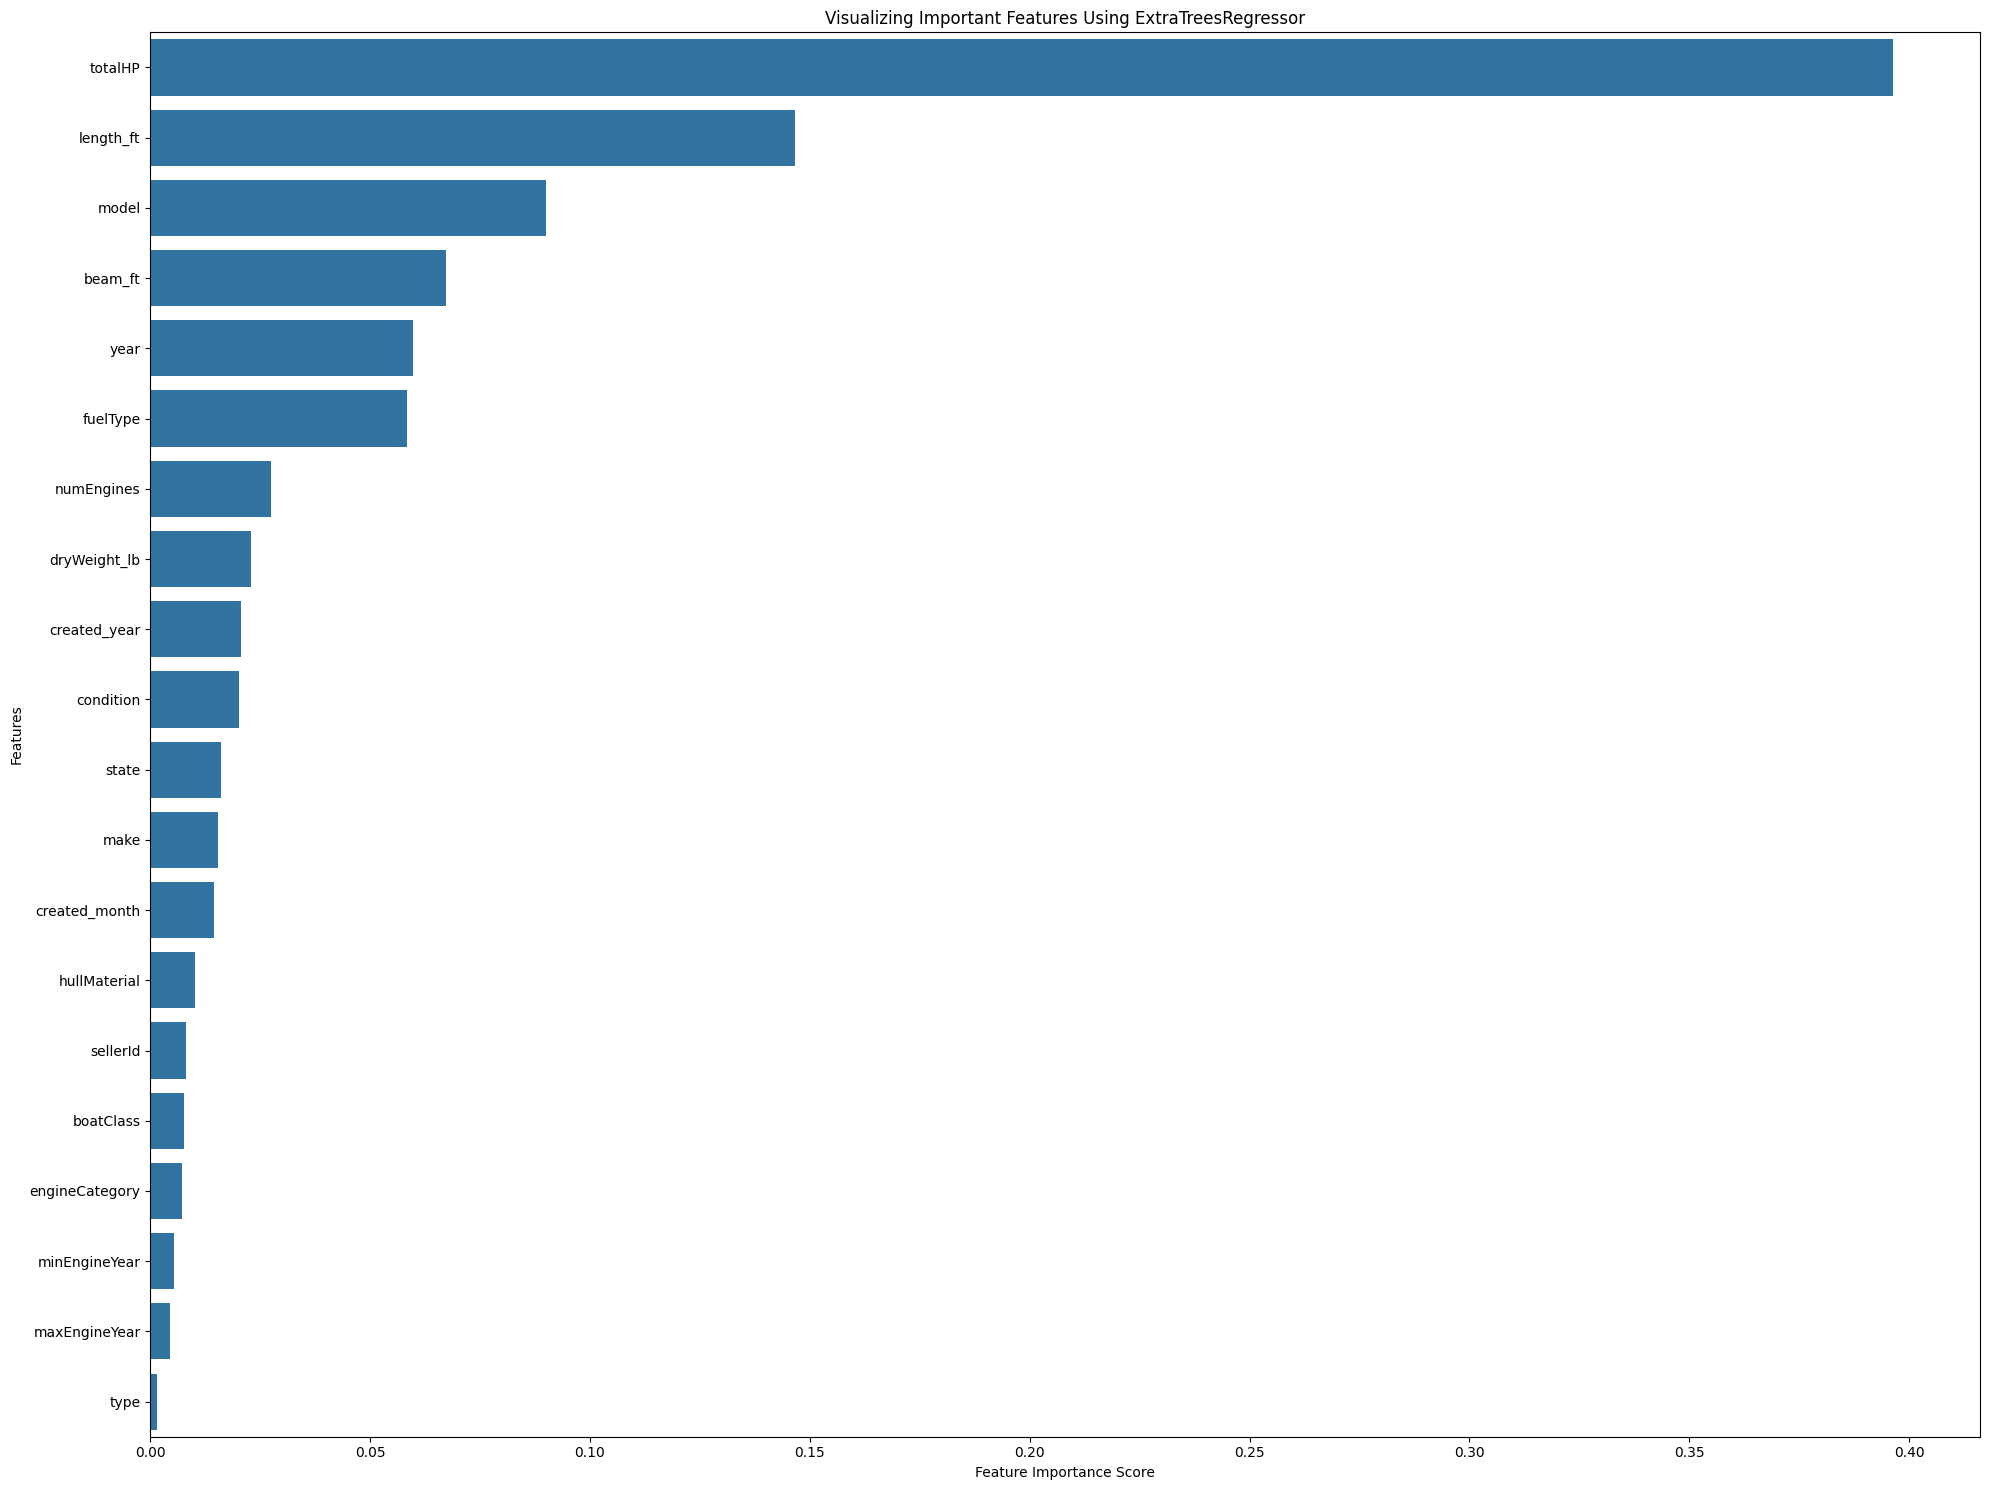

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sns
import matplotlib.pyplot as plt


# Huấn luyện mô hình Extra Trees Regressor
clf = ExtraTreesRegressor(n_estimators=100)
clf.fit(X_train, y_train)

# Lấy tầm quan trọng của các đặc trưng
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Vẽ biểu đồ tầm quan trọng của các đặc trưng
plt.figure(figsize=(20, 15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Using ExtraTreesRegressor")
plt.tight_layout()
plt.show()


In [ ]:
dataset.drop(["type"], axis=1, inplace=True)
dataset.drop(["maxEngineYear"], axis=1, inplace=True)
dataset.drop(["minEngineYear"], axis=1, inplace=True)
dataset.drop(["hullMaterial"], axis=1, inplace=True)
dataset.drop(["engineCategory"], axis=1, inplace=True)
dataset.drop(["boatClass"], axis=1, inplace=True)
dataset.drop(["sellerId"], axis=1, inplace=True)
dataset.drop(["created_month"], axis=1, inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18901 entries, 0 to 18902
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          18901 non-null  float64
 1   length_ft     18901 non-null  float64
 2   beam_ft       18901 non-null  float64
 3   dryWeight_lb  18901 non-null  float64
 4   numEngines    18901 non-null  float64
 5   totalHP       18901 non-null  float64
 6   price         18901 non-null  float64
 7   created_year  18901 non-null  float64
 8   make          18901 non-null  int64  
 9   model         18901 non-null  int64  
 10  condition     18901 non-null  int64  
 11  fuelType      18901 non-null  int64  
 12  state         18901 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 2.0 MB


In [ ]:
data_2_train = dataset.copy()

y = data_2_train['price']
data_2_train.drop(["price"], axis=1, inplace=True)
X = data_2_train

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the Neural Network model (FNN)
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Prepare data for neural network
X_train_nn = X_train
X_test_nn = X_test

# Build and train the model
nn_model = build_nn_model(X_train_nn.shape[1])
nn_model.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict and evaluate the model
y_pred_nn = nn_model.predict(X_test_nn).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

Epoch 1/50
355/355 [==============================] - 3s 5ms/step - loss: 0.4149 - mean_absolute_error: 0.1701 - val_loss: 1.4956 - val_mean_absolute_error: 0.1847
Epoch 2/50
355/355 [==============================] - 1s 2ms/step - loss: 0.3042 - mean_absolute_error: 0.1458 - val_loss: 1.5651 - val_mean_absolute_error: 0.1696
Epoch 3/50
355/355 [==============================] - 1s 2ms/step - loss: 0.2233 - mean_absolute_error: 0.1283 - val_loss: 1.2761 - val_mean_absolute_error: 0.1831
Epoch 4/50
355/355 [==============================] - 1s 2ms/step - loss: 0.1961 - mean_absolute_error: 0.1347 - val_loss: 1.2494 - val_mean_absolute_error: 0.1483
Epoch 5/50
355/355 [==============================] - 1s 2ms/step - loss: 0.1618 - mean_absolute_error: 0.1216 - val_loss: 1.2095 - val_mean_absolute_error: 0.1509
Epoch 6/50
355/355 [==============================] - 1s 2ms/step - loss: 0.1450 - mean_absolute_error: 0.1232 - val_loss: 1.1492 - val_mean_absolute_error: 0.1394
Epoch 7/50
355/3

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "MAE", "MSE", "R²"]

# Add rows for selected features
table.add_row(["Decision Tree", mae_dt, mse_dt, r2_dt])
table.add_row(["Random Forest", mae_rf, mse_rf, r2_rf])
table.add_row(["Neural Network", mae_nn, mse_nn, r2_nn])

print(table)


+----------------+---------------------+---------------------+--------------------+
|     Model      |         MAE         |         MSE         |         R²         |
+----------------+---------------------+---------------------+--------------------+
| Decision Tree  | 0.09425344453185994 |  0.2217785217961093 | 0.686546294905075  |
| Random Forest  | 0.06823109350486566 | 0.10307658343579201 | 0.8543153019291069 |
| Neural Network | 0.10696840193288089 | 0.16755633266411213 | 0.7631819670348027 |
+----------------+---------------------+---------------------+--------------------+
